In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/plant_dataset_split - Copy.zip" -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1071).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (109).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1094).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1108).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1109).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (112).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1121).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1135).JPG  
  inflating: /content/dataset/plant_dataset_split - Copy/val/Pepper,_bell___healthy/image (1137).JPG  
  inflating: /content/da

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_path = '/content/dataset/plant_dataset_split - Copy/train'
val_path = '/content/dataset/plant_dataset_split - Copy/val'
test_path = '/content/dataset/plant_dataset_split - Copy/test'

In [5]:
# Image parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 49179 images belonging to 39 classes.
Found 9213 images belonging to 39 classes.
Found 3094 images belonging to 39 classes.


In [6]:
# Get number of classes and class names
NUM_CLASSES = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names: {class_names}")

Number of classes: 39
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot'

In [7]:
# Compute class weights for imbalance
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_path, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

total_samples = sum(class_counts.values())
class_weights = {train_generator.class_indices[class_name]: total_samples / (NUM_CLASSES * count)
                 for class_name, count in class_counts.items()}
print("Class weights:", class_weights)

Class weights: {0: 1.57625, 1: 1.57625, 2: 1.57625, 3: 0.9582066869300911, 4: 1.3796498905908097, 5: 1.0499583680266444, 6: 1.4994054696789536, 7: 1.57625, 8: 1.57625, 9: 1.323189926547744, 10: 1.57625, 11: 1.3573735199138859, 12: 1.3358050847457628, 13: 1.1401446654611211, 14: 1.466279069767442, 15: 1.57625, 16: 0.2862656072644722, 17: 0.6864452912357104, 18: 1.57625, 19: 1.57625, 20: 1.0668358714043993, 21: 1.57625, 22: 1.57625, 23: 1.57625, 24: 1.57625, 25: 0.3096758349705305, 26: 0.8589918256130791, 27: 1.4216459977452085, 28: 1.57625, 29: 0.7413286302175192, 30: 1.57625, 31: 0.8258022265880812, 32: 1.57625, 33: 0.8905367231638418, 34: 0.941044776119403, 35: 1.1228851291184327, 36: 0.29428238039673277, 37: 1.57625, 38: 0.9913522012578616}


In [8]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 39)             │         5,031 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,553,959 (25.00 MB)

 Trainable params: 6,553,959 (25.00 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


768/768 ━━━━━━━━━━━━━━━━━━━━ 76s 90ms/step - accuracy: 0.1573 - loss: 3.1778 - val_accuracy: 0.5828 - val_loss: 1.4825
Epoch 2/20
  1/768 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.4375 - loss: 2.3471

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


768/768 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4375 - loss: 2.3471 - val_accuracy: 0.5974 - val_loss: 1.4579
Epoch 3/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 81s 106ms/step - accuracy: 0.5085 - loss: 1.7085 - val_accuracy: 0.7682 - val_loss: 0.8405
Epoch 4/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.5938 - loss: 1.4978 - val_accuracy: 0.7599 - val_loss: 0.8590
Epoch 5/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 117s 85ms/step - accuracy: 0.6470 - loss: 1.2201 - val_accuracy: 0.8181 - val_loss: 0.6079
Epoch 6/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6719 - loss: 1.1682 - val_accuracy: 0.8164 - val_loss: 0.6143
Epoch 7/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 72s 85ms/step - accuracy: 0.7263 - loss: 0.9333 - val_accuracy: 0.8645 - val_loss: 0.4582
Epoch 8/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7188 - loss: 0.9654 - val_accuracy: 0.8619 - val_loss: 0.4671
Epoch 9/20
768/768 ━━━━━━━━━━━━━━━━━━━━ 66s 85ms/step - accuracy: 0.7703 - loss: 0.7724 - val_accuracy:

In [13]:
model.save('/content/drive/My Drive/crop_disease_cnn_batch64.keras')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/crop_disease_cnn.keras')

In [10]:
# Evaluate on test set
test_generator.reset()
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes[:len(y_pred_classes)]

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9191 - loss: 0.2573
Test Loss: 0.2885, Test Accuracy: 0.9053
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step
Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.87      0.78      0.82        50
                            Apple___Black_rot       0.83      0.98      0.90        50
                     Apple___Cedar_apple_rust       0.94      0.94      0.94        50
                              Apple___healthy       0.89      0.92      0.90        83
                    Background_without_leaves       0.92      0.98      0.95        58
                          Blueberry___healthy       0.94      0.99      0.96        76
                      Cherry___Powdery_mildew       0.91      0.93      0.92        54
                             Cherry___healthy       0.87      0.94      0.90        50
   Corn___Cercospora_leaf_spot Gray_le

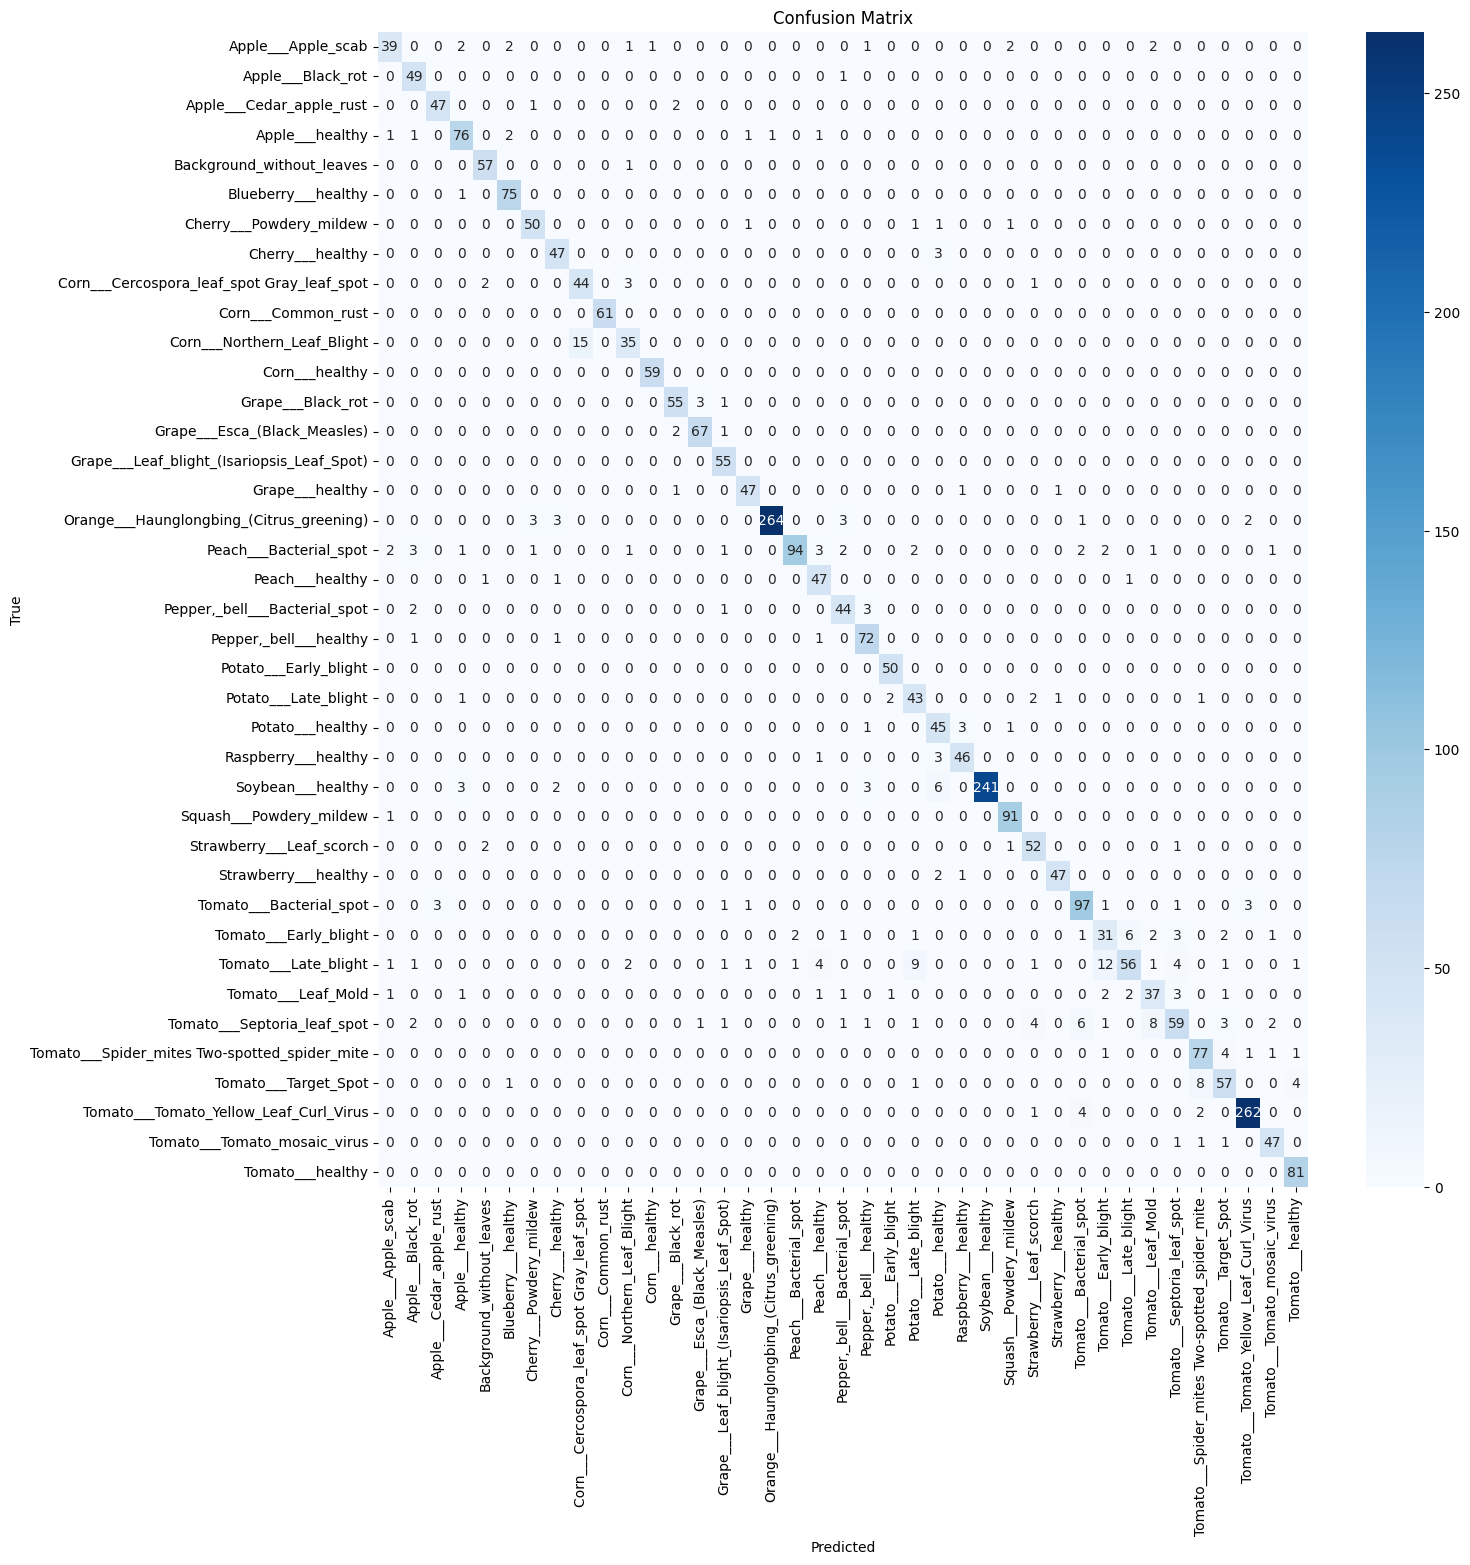

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



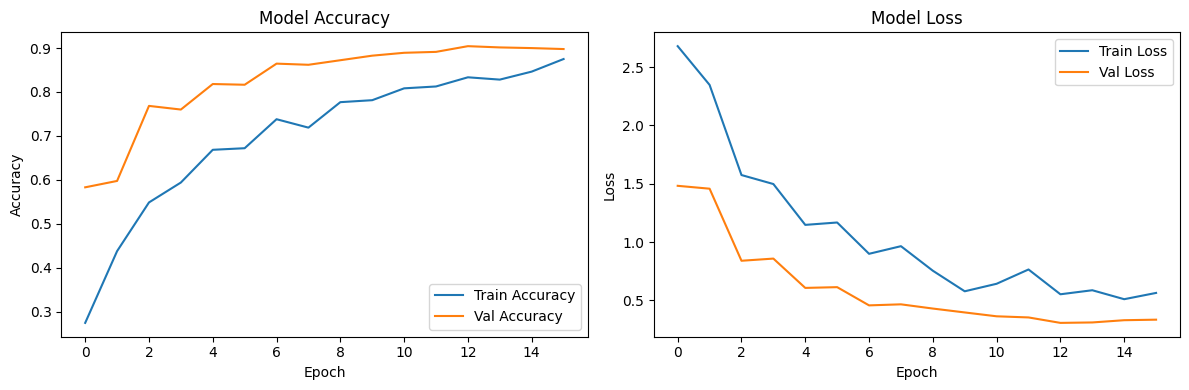

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

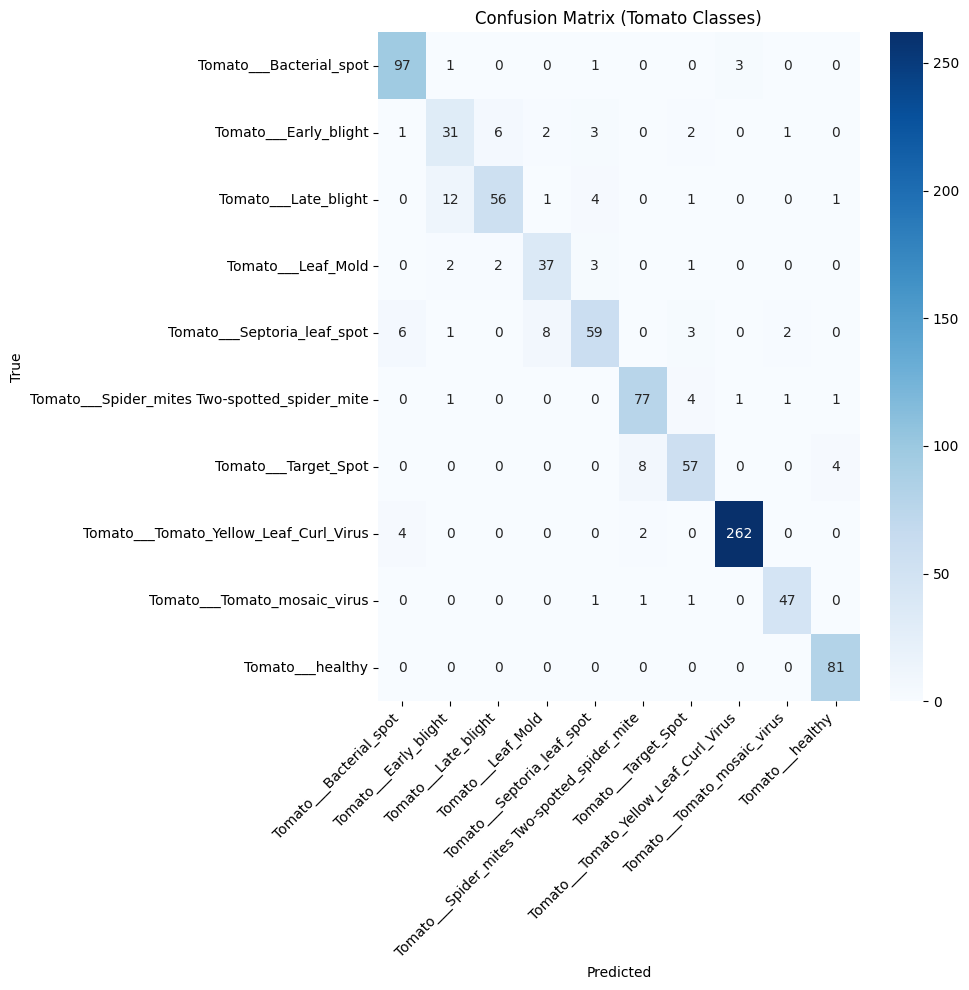

In [14]:
tomato_classes = [i for i, name in enumerate(class_names) if 'Tomato' in name]
cm_tomato = cm[tomato_classes][:, tomato_classes]
class_names_tomato = [class_names[i] for i in tomato_classes]
plt.figure(figsize=(10, 10))
sns.heatmap(cm_tomato, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_tomato, yticklabels=class_names_tomato)
plt.title('Confusion Matrix (Tomato Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()